<h2> Classification of Celeb_A Dataset </h2> 

- Building of pipeline for dataprocessing
- Using Pretrained CNN(Transfer Learning) and parameter tuning 

The Celeb_A dataset contains 202599 images, however we shall use only 50000 images due to performance limitations and speed of training.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import re
import os

In [2]:
image_limit = 50000
dataset_source_path = r'D:\My Stuff\Datasets\Celeb_A\img_align_celeba'

In [3]:
image_list = os.listdir(dataset_source_path)
image_list[0]

'000001.jpg'

In [20]:
labels_path = os.path.join(r'D:\My Stuff\Datasets\Celeb_A',r'list_attr_celeba.txt')
labels_df = pd.read_csv(labels_path, header = [1])

In [50]:
def prep_label_rows(row):
    row_items = row[0].split()
    row_items[1:] = list(map(int,row_items[1:]))
    return row_items

In [35]:
columns = labels_df.columns.tolist()[0].split()
columns.insert(0,'Image')

In [37]:
df_size = labels_df.shape[0]

In [47]:
list_of_rows = labels_df.to_numpy().tolist()

In [51]:
list_of_rows = list(map(prep_label_rows,list_of_rows))

In [4]:
#creating a file path list
image_file_paths = [os.path.join(dataset_source_path,image_list[i]) for i in range(image_limit)]

In [5]:
#split the data into train,test,validation sets 
train_set = image_file_paths[:30000]
valid_set = image_file_paths[30000:40000]
test_set = image_file_paths[40000:]

In [6]:
def convert_image_to_pixels(filepath):
    image = tf.io.read_file(filepath)
    image_pixels = tf.io.decode_image(image, channels = 3, dtype = tf.float32)
    return image_pixels

In [7]:
train_ds = tf.data.Dataset.list_files(train_set)
valid_ds = tf.data.Dataset.list_files(valid_set)
test_ds = tf.data.Dataset.list_files(test_set)

In [8]:
train_ds = train_ds.map(convert_image_to_pixels)

In [9]:
import matplotlib.pyplot as plt

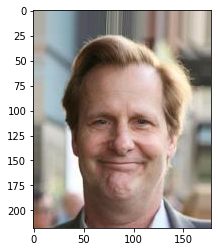

In [14]:
for image in train_ds.take(2):
    plt.imshow(image)